<a href="https://colab.research.google.com/github/NneomaOkafor/HousingCAD/blob/main/Milestone_3_Initial_Results_and_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nneoma Okafor
To replicate the framework in the paper the following steps were applied:
1. Splitting the dataset into training (first 402 months) and testing (last 48 months).

2. Further splitting the training set into hyperparameter tuning (first 302 months).

3. Performing rolling one-step-ahead forecasts using cross-validation.

4. Calculating RMSE for both machine learning and OLS models.

5. Optimizing hyperparameters based on relative RMSE.

In [1]:
# 1. Data Loading and Sorting
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/FINAL PROJECT/Python files/Project_set_in_use.csv')
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 1.1 Initial Cleaning
predictor_cols = df.columns.difference(["Date", "Aggregate Composite MLS HPI"])
X_raw = df[predictor_cols].copy()
y = df["Aggregate Composite MLS HPI"].values
X_raw = df[predictor_cols].drop(columns=[col for col in predictor_cols if "Average_Price" in col])

# 1.2 Feature Construction (Lag Features)
MAX_LAG = 6
def make_lags(df_in, max_lag):
    out = df_in.copy()
    for lag in range(1, max_lag + 1):
        out = out.join(df_in.shift(lag).add_suffix(f"_lag{lag}"))
    return out

X_lagged = make_lags(X_raw, MAX_LAG)

# 1.3 Feature Filtering
X_lagged["Aggregate Composite MLS HPI"] = df["Aggregate Composite MLS HPI"]
X_lagged = X_lagged.dropna()
y = X_lagged["Aggregate Composite MLS HPI"]
X_lagged = X_lagged.drop(columns=["Aggregate Composite MLS HPI"])

# 2. Model Development

# 2.1 Feature Selection using ElasticNetCV
pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("enet", ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],
        n_alphas=50,
        max_iter=10000,
        cv=TimeSeriesSplit(n_splits=5),
        random_state=42
    ))
])

pipeline.fit(X_lagged, y)

best_alpha = pipeline.named_steps["enet"].l1_ratio_
best_lambda = pipeline.named_steps["enet"].alpha_
print(f"Best α (l1_ratio): {best_alpha},  Best λ: {best_lambda:.4f}")

coefs = pipeline.named_steps["enet"].coef_
selected = pd.Series(coefs, index=X_lagged.columns)
selected_nonzero = selected[selected != 0].sort_values(key=np.abs, ascending=False)
print(f"\nSelected {selected_nonzero.shape[0]} variables out of {len(coefs)}:")
display(selected_nonzero.head(20))

# 2.2 Train-Test Splitting
N = len(X_lagged)
print(f"Total rows in X_lagged: {N}")

if N < 450:
    print("Not enough samples for 402/48 split. Adjusting split.")
    split_point = max(0, N - 48)
    X_train_full = X_lagged.iloc[:split_point]
    y_train_full = y[:split_point]
    X_test = X_lagged.iloc[split_point:]
    y_test = y[split_point:]
else:
    X_train_full = X_lagged.iloc[:402]
    y_train_full = y[:402]
    X_test = X_lagged.iloc[402:]
    y_test = y[402:]

X_tune = X_train_full.iloc[:302]
y_tune = y_train_full[:302]

# 2.3 Hyperparameter Grid for Random Forest
param_grid = {
    'n_estimators': [50],
    'max_depth': [5, None]
}
grid = ParameterGrid(param_grid)

# 3. Model Evaluation Functions

# 3.1 Rolling CV for Linear Regression
def rolling_cv_rmse_linear(X, y, window=120):
    rmses = []
    skipped = 0
    for start in range(len(X) - window):
        X_train = X.iloc[start:start + window]
        y_train = y[start:start + window]
        X_val = X.iloc[start + window:start + window + 1]
        y_val = y[start + window:start + window + 1]

        if X_val.isnull().values.any() or y_val.isnull().values.any():
            skipped += 1
            continue

        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmses.append(rmse)

    print(f"Linear RMSE: {np.mean(rmses) if rmses else 'NaN'}")
    print(f"Folds used: {len(rmses)}")
    print(f"Folds skipped due to NaNs: {skipped}")
    return np.mean(rmses) if rmses else np.nan

# 3.2 Rolling CV for Random Forest
def rolling_cv_rmse(model_class, params, X, y, window=120):
    rmses = []
    for start in range(len(X) - window):
        X_train = X.iloc[start:start + window]
        y_train = y[start:start + window]
        X_val = X.iloc[start + window:start + window + 1]
        y_val = y[start + window:start + window + 1]

        if X_val.isnull().values.any() or y_val.isnull().values.any():
            continue

        model = model_class(**params, n_jobs=-1)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmses.append(rmse)

    print(f"Rolling CV (ML, params={params}): {len(rmses)} folds used.")
    return np.mean(rmses) if rmses else np.nan

# 4. Model Tuning and Final Testing

window = 120
baseline_rmse = rolling_cv_rmse_linear(X_tune, y_tune, window=window)

best_params = None
best_rel_rmse = float('inf')

if np.isnan(baseline_rmse) or baseline_rmse == 0:
    print("Baseline RMSE is invalid. Skipping model comparison.")
else:
    for params in grid:
        ml_rmse = rolling_cv_rmse(RandomForestRegressor, params, X_tune, y_tune, window=window)
        rel_rmse = ml_rmse / baseline_rmse
        print(f"Params: {params}, Relative RMSE: {rel_rmse:.4f}")
        if not np.isnan(rel_rmse) and rel_rmse < best_rel_rmse:
            best_rel_rmse = rel_rmse
            best_params = params

    print("\nBest Params:", best_params)
    print("Best Relative RMSE:", best_rel_rmse)

    if best_params is not None:
        final_model = RandomForestRegressor(**best_params)
        final_model.fit(X_train_full, y_train_full)
        final_preds = final_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
        print("Test RMSE (Out-of-sample):", test_rmse)
    else:
        print("Skipping final model training: No valid hyperparameters found.")


Best α (l1_ratio): 0.9,  Best λ: 75.7002

Selected 2672 variables out of 2870:


,0
CLAIMS_QC,-1653.157341
CLAIMS_QC_lag1,-1597.336358
CLAIMS_QC_lag4,-1589.197580
CLAIMS_QC_lag3,-1584.016334
CLAIMS_QC_lag2,-1571.424316
CLAIMS_QC_lag5,-1567.065866
CLAIMS_QC_lag6,-1554.250675
CLAIMS_ALB_lag6,1450.047830
CLAIMS_ALB_lag5,1360.145761
N_DUR_INV_RAT_new_lag6,1289.870646


Total rows in X_lagged: 189
Not enough samples for 402/48 split. Adjusting split.
Linear RMSE: 55251.188093956414
Folds used: 21
Folds skipped due to NaNs: 0
Rolling CV (ML, params={'max_depth': 5, 'n_estimators': 50}): 21 folds used.
Params: {'max_depth': 5, 'n_estimators': 50}, Relative RMSE: 0.8532
Rolling CV (ML, params={'max_depth': None, 'n_estimators': 50}): 21 folds used.
Params: {'max_depth': None, 'n_estimators': 50}, Relative RMSE: 0.8822

Best Params: {'max_depth': 5, 'n_estimators': 50}
Best Relative RMSE: 0.8531680879706018
Test RMSE (Out-of-sample): 142713.87990388376


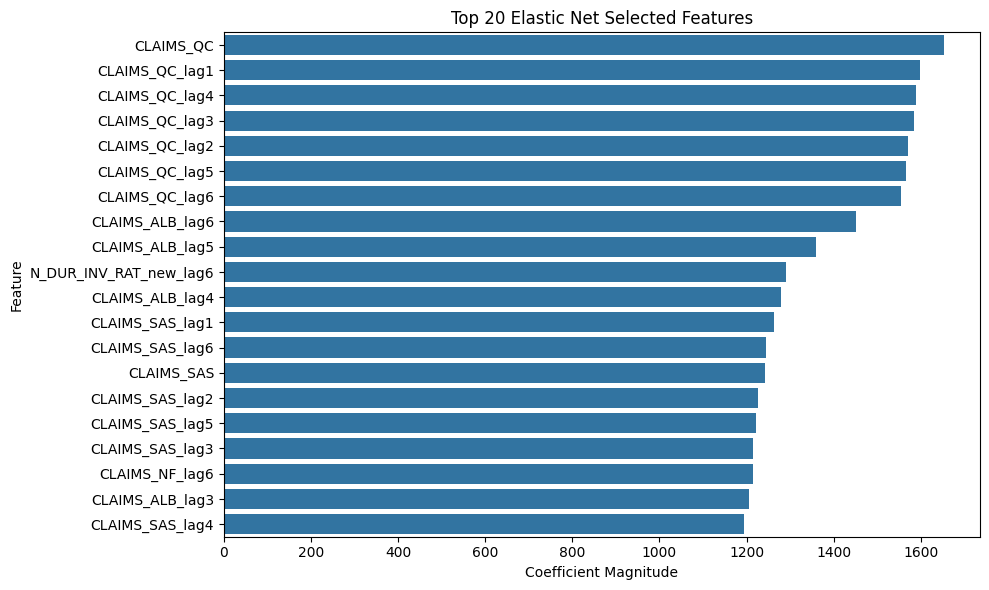

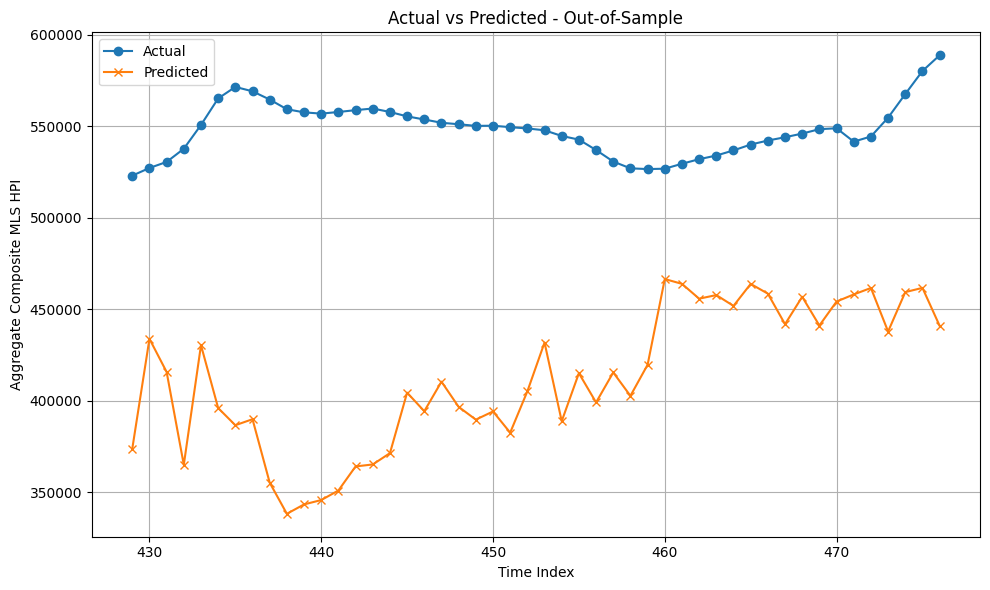

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot the top Elastic Net coefficients
def plot_top_features(selected_series, top_n=20):
    top_features = selected_series.abs().sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f"Top {top_n} Elastic Net Selected Features")
    plt.xlabel("Coefficient Magnitude")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_top_features(selected_nonzero)

# 2. Plot actual vs predicted on test set
def plot_actual_vs_pred(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true.index, y_true.values, label="Actual", marker='o')
    plt.plot(y_true.index, y_pred, label="Predicted", marker='x')
    plt.title("Actual vs Predicted - Out-of-Sample")
    plt.xlabel("Time Index")
    plt.ylabel("Aggregate Composite MLS HPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Make sure y_test is a Series with same index as X_test
y_test_series = pd.Series(y_test, index=X_test.index)
plot_actual_vs_pred(y_test_series, final_preds)
